# make a plot comparing motile and non-motile taxa

In [86]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 

In [60]:
residual_community_taxa = pd.read_csv('../output_files/residual_community_bracken_species_confidence_0.1.tsv', sep = '\t', index_col = 'name')
residual_community_taxa_abund = residual_community_taxa/residual_community_taxa.sum()

# read in metadata to get the ordering of the samples 
metadata = pd.read_csv('../metadata/residual_community_metadata.csv')
fame_order = dict(zip(metadata['FAME ID (leave blank)'], metadata['Order']))

In [92]:
non_motile = ['Lactococcus raffinolactis', 
             'Bacteroides graminisolvens', 
             'uncultured Bacteroides sp.',
              'Klebsiella penumoniae', 
              'Raoultella ornithinolytica',  
              'uncultured Tolumonas sp.', 
              'Prevotella herbatica', 
              'Lactococcus lactis', 
              'Klebsiella huaxiensis', 
              'Klebsiella michiganensis', 
              'Klebsiella quasipneumoniae',
              'Raoultella planticola', 
              'Klebsiella aerogenes', 
              'Klebsiella grimontii'
            ]
non_motile_abund = residual_community_taxa_abund[residual_community_taxa_abund.index.isin(non_motile)]
non_motile_long = non_motile_abund.stack().reset_index()
non_motile_long['order'] = [fame_order.get(i)  for i in non_motile_long['level_1']]
non_motile_long['genus'] = [re.split(' ',i)[0] for i in non_motile_long['name']]

In [118]:
non_motile_long

,name,level_1,0,order,genus,Distance (cm),distance
0,Klebsiella michiganensis,FAME000105,3.462166e-04,10,Klebsiella,0.001039,0.001039
1,Klebsiella michiganensis,FAME000106,3.780342e-04,11,Klebsiella,0.001134,0.001134
2,Klebsiella michiganensis,FAME000107,2.088960e-04,12,Klebsiella,0.000627,0.000627
3,Klebsiella michiganensis,FAME000108,2.745003e-04,13,Klebsiella,0.000824,0.000824
4,Klebsiella michiganensis,FAME000109,1.791444e-04,14,Klebsiella,0.000537,0.000537
...,...,...,...,...,...,...,...
339,uncultured Bacteroides sp.,FAME000130,3.461583e-07,8,Bacteroides,0.000001,0.000001
340,uncultured Bacteroides sp.,FAME000131,1.229492e-06,9,Bacteroides,0.000004,0.000004
341,uncultured Bacteroides sp.,FAME000104,7.682645e-02,1,Bacteroides,0.230479,0.230479
342,uncultured Bacteroides sp.,FAME000124,6.843920e-06,28,Bacteroides,0.000021,0.000021


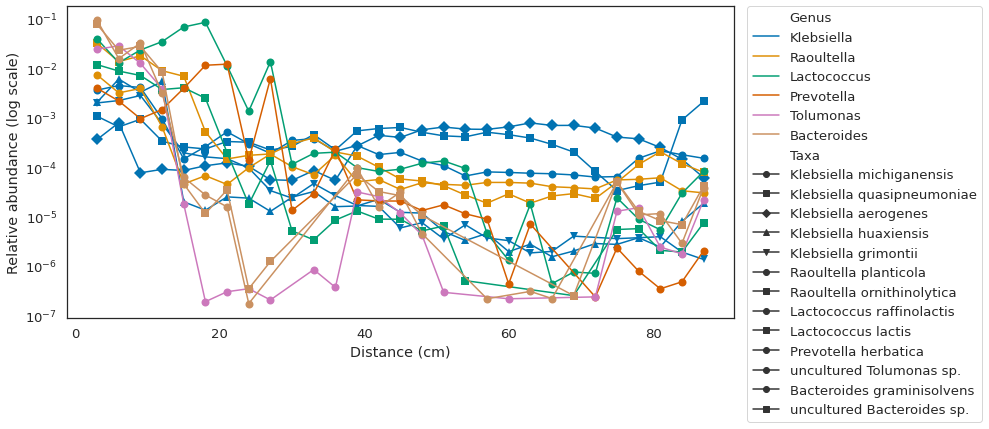

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pandas as pd

sns.set(font_scale=1.2, style='white')

# If not already present, create a 'genus' column
def get_genus(name: str) -> str:
    parts = str(name).split()
    # Handle "uncultured X sp." style names
    return parts[1] if parts and parts[0].lower() == "uncultured" and len(parts) > 1 else parts[0]

non_motile_long = non_motile_long.copy()
non_motile_long["genus"] = non_motile_long["name"].apply(get_genus)
non_motile_long["distance"] = non_motile_long["order"] * 3

# Species order (optional but helps keep legend/order stable)
species_levels = [
    'Klebsiella michiganensis', 'Klebsiella quasipneumoniae',
    'Klebsiella aerogenes', 'Klebsiella huaxiensis', 'Klebsiella grimontii',
    'Raoultella planticola', 'Raoultella ornithinolytica',
    'Lactococcus raffinolactis', 'Lactococcus lactis',
    'Prevotella herbatica', 'uncultured Tolumonas sp.',
    'Bacteroides graminisolvens', 'uncultured Bacteroides sp.'
]
non_motile_long["name"] = pd.Categorical(non_motile_long["name"], categories=species_levels, ordered=True)

# Marker pool to reuse within each genus (≥ max species per genus)
marker_pool = ["o", "s", "D", "^", "v", "P", "X"]

# Build a mapping {species_name: marker}, cycling the pool separately for each genus
marker_map = {}
for genus, subdf in non_motile_long.groupby("genus", observed=True):
    cyc = itertools.cycle(marker_pool)
    for sp in subdf["name"].dropna().unique():
        if sp not in marker_map:
            marker_map[sp] = next(cyc)

plt.figure(figsize=(14, 6))  # wider figure

ax = sns.lineplot(
    data=non_motile_long,
    x="distance",
    y=0,
    hue="genus",          # colour by genus
    style="name",         # different markers by species
    markers=marker_map,   # reuse marker pool within each genus
    dashes=False,         # no dashes
    markersize=8,
    linewidth=1.5,
    markeredgewidth=0,    # remove marker outlines
    markeredgecolor="none", 
    palette='colorblind'
)

# Log y-axis
ax.set_yscale("log")

# Legend outside
leg = ax.legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

# Rename legend section headings: 'genus' -> 'Genus', 'name' -> 'Taxa'
# (Seaborn puts these as text entries in the legend; adjust in place)
for txt in leg.get_texts():
    t = txt.get_text()
    if t == "genus":
        txt.set_text("Genus")
    elif t == "name":
        txt.set_text("Taxa")

ax.set_xlabel("Distance (cm)")
ax.set_ylabel("Relative abundance (log scale)")

plt.tight_layout()
plt.savefig('../figures/residual_community_non_motile.png', dpi=300)
plt.show()
